# Introduction

### What is Call of Duty/Warzone?

Call of Duty is a very popular video game series published by Activision. Recently, its free-to-play game Warzone has come into great popularity, specifically with the rise of Battle Royale type games. With this rise has also come a very large community that is very competitive. These players started to realize that the game's lack of a ranking system did not match up with their own matchmaking experience. Thus, players have started to wonder if there is a hidden skill-based matchmaking system present in the game.

### Why would someone care about their matchmaking?

In general, all gamers care about their gaming experience. It's obviously not fun to consistently lose, but its also not fun to consistently win. Finding the balance, is very important to staying interested in a game for a long time. So, both from a consumer and developer standpoint, matchmaking is integral to keeping a video game relevant. While this is the case, not being able to see your performance in relation to matchmaking is removing a significant part of the experience from players. In other very popular video games such as League of Legends, Apex Legends, Valorant, and even FIFA all show their players their ranking and progression through the ranked tier system. In Warzone, such a system does not exist, and this leads players to question the skill levels of their opponents and themselves.

 In addition, there is also the possibility that Activision has a financial incentive to modify matchmaking, especially at the content creator level. The reasoning behind this is that content creators hold great influence over potential customers, and giving them a good experience might lead to more customers.

### What exactly is skill based matchmaking?

Skill based matchmaking is a system that matches players in a game based on some ranking. This ranking can be whatever metric the developers choose, but is often implemented as an ELO score or a custom MMR (matchmaking rating) score fitting the game's qualities.

### What is the goal of our project?

We will be exploring two main questions for this project. 

The first question will be "Is there skill-based matchmaking in Call of Duty: Warzone?". This question is a very common one amongst the COD user base and being members of this user base, we wanted to find out an answer.

The second question is arguably juicier because it puts Activision in the hot seat. We will be trying to answer "Does Activision purposefully lower the matchmaking difficulty of content creators?".  

Due to the fact that the game has a very passionate community, learning the answers to these questions can be very insightful for the input fans want to give to developers. For the content creators, players who are also passionate viewers of COD on Twitch or YouTube might rethink their opinions of whoever they watch.

# Data Collection

Due to the specific nature of this project, we had to find creative ways to collect data regarding Call of Duty matchmaking information. Luckily, there is a Call of Duty API that enables developers to look at past match data and stats for specific players. However, Call of Duty's official API enforces a setting where accounts must set their visibility to public for their profiles to be viewable. However, some third party APIs aggregate data across games and paint a clearer picture of players' statistics. One of these is [WZStats.gg](http://wzstats.gg) (Warzone Stats) and they show detailed per match data. By using their website and its API, we are able to get the data of many players that will help to inform our research question. 

Because it is a manual process to set your profile to public visibility, it is likely that better-skilled players are going to be the ones with visible profiles. This potentially limits our visibility into the player skill spectrum. If there is skill-based matchmaking, the initial accounts, and their respective game history, that we are analyzing, will be biased towards higher tier skill levels because these players care a lot more about their stats than lower-skilled players and would be more likely to set their profiles to public. However, if there is no skill-based matchmaking, then the game lobbies will be entirely random as far as skill is concerned (there could be other factors such as network latency and global location). With random lobbies, we will hypothetically be able to tap into the entire spectrum of players if we analyze enough games.

As said, there is no existing database, so we needed to write code that could help create one. In order to do so, we first started by assembling a list of profiles that had public visibility. This included some of our own accounts and also those of pro players and content creators. As mentioned previously, looking at content creators' accounts could provide some insight into our second question, whether the matchmaking skill level of content creators' lobbies were lower. 

The data collection process ended up being quite complicated for us. In fact, we spent 6 hours on this and had to try it about seven times. Ooops. So what went wrong? Our initial collection process was essentially built on the perspective of this problem through graph theory. Specifically, we wanted to preform a breath first traversal of a lot of accounts, to attempt to sample the player base as effective as possible. The plan was to start with the 10 seed accounts, as described earlier, and then treat each player as a new node, eliminating those who have been visited already,  and continnue to analyze each persons' previous 20 matches. This analysis, more so data gathering, include capturing, all (up to) 150 players per lobby and the lifetime kds for each player in the lobby. Where was our logic faulty? Breadth first search only works under the assumption that there is no skill based match making. Specifically, if there is no skill based match making, then the breadth first search would allow us to branch away form the current lobby and to various different skill levels quite quickly, with few degrees of separation, if any at all. However, if there is skill based matching making, then we would be stuck in the same spectrum of the skill distribution and we wouled be unable to reach the rest of the player base unless our initial seed accounts were perfectly distributed across the spectrum of plauers, which they are not. 

So, we move to method two. Method two entails a pivot away from the breadth first search and moves towards a depth first search, or rather a graph traversal with a split factor of 2. More specficially, in order to achieve a better sampling, starting at one player, we randomly sample 2 players from their most recent match lobby. If we can successfully sample 2 accounts with public data settings, then we add them to our queue, and then repeat the process that we did on the initial player. We aim to do this repeatedly to achieve 11 degrees of separation from the original account. We arbitirarily selected a professional content creator's account, NICKMERCS, as the initial account and let the program run overnight, sampling 2^11 

Each of these scripts implement "wzstats.py" which is the script we wrote that implements scraping data from wzstats.gg, the data aggregating site mentioned previously in this writeup. The following code is contained within wzstats.py:

In [8]:
import requests
from bs4 import BeautifulSoup
import time
import csv
import pandas as pd
import unidecode

# Xbox = xbox
# Battle.net = battle
# Playstation = psn

XBOX = 'xbl'
BNET = 'battle'
PSN = 'psn'

def getKD(user, platform):
    params = {
        'username': user,
        'platform': platform
    }

    r = requests.get('https://app.wzstats.gg/v2/player', params=params)

    return r.json()['data']['lifetime']['mode']['br']['properties']['kdRatio']

def getWins(user, platform):
    params = {
        'username': user,
        'platform': platform
    }

    r = requests.get('https://app.wzstats.gg/v2/player', params=params)

    j = r.json()

    return j['data']['lifetime']['mode']['br']['properties']['wins']

def getWinPct(user, platform):
    params = {
        'username': user,
        'platform': platform
    }

    r = requests.get('https://app.wzstats.gg/v2/player', params=params)

    j = r.json()

    return ((j['data']['lifetime']['mode']['br']['properties']['wins'] / j['data']['lifetime']['mode']['br']['properties']['gamesPlayed']) * 100)

def getKills(user, platform):
    params = {
        'username': user,
        'platform': platform
    }

    r = requests.get('https://app.wzstats.gg/v2/player', params=params)

    j = r.json()

    return j['data']['lifetime']['mode']['br']['properties']['kills']

def getKillsPerGame(user, platform):
    params = {
        'username': user,
        'platform': platform
    }

    r = requests.get('https://app.wzstats.gg/v2/player', params=params)

    j = r.json()

    return (j['data']['lifetime']['mode']['br']['properties']['kills'] / j['data']['lifetime']['mode']['br']['properties']['gamesPlayed'])

def getGulagLast100(user, platform):
    params = {
        'username': user,
        'platform': platform
    }

    r = requests.get('https://app.wzstats.gg/v2/player', params=params)

    j = r.json()

    return j['last100games']['gulagWinPercentage']

def getHSLast100(user, platform):
    params = {
        'username': user,
        'platform': platform
    }

    r = requests.get('https://app.wzstats.gg/v2/player', params=params)

    j = r.json()

    return (j['last100games']['headshots'] / j['last100games']['kills'])

def getKDLast100(user, platform):
    params = {
        'username': user,
        'platform': platform
    }

    r = requests.get('https://app.wzstats.gg/v2/player', params=params)

    j = r.json()

    return (j['last100games']['kills'] / j['last100games']['deaths'])

def getLast20Matches(user, platform):
    params = {
        'username': user,
        'platform': platform
    }

    r = requests.get('https://app.wzstats.gg/v2/player/match', params=params)

    j = r.json()
    
    matches = []

    for m in j:
        matches.append(m['id'])

    return matches

def getAvgKDMatch(match):
    params = {
        'matchId': match
    }

    r = requests.get('https://app.wzstats.gg/v2/', params=params)

    j = r.json()

    return j['matchStatData']['playerAverage']

def getMedianKDMatch(match):
    params = {
        'matchId': match
    }

    r = requests.get('https://app.wzstats.gg/v2/', params=params)

    j = r.json()

    return j['matchStatData']['playerMedian']

def getAvgTeamKDMatch(match):
    params = {
        'matchId': match
    }

    r = requests.get('https://app.wzstats.gg/v2/', params=params)

    j = r.json()

    return j['matchStatData']['teamAverage']

def getMedianTeamKDMatch(match):
    params = {
        'matchId': match
    }

    r = requests.get('https://app.wzstats.gg/v2/', params=params)

    j = r.json()

    return j['matchStatData']['teamMedian']

seen_accounts = []

def getLobbyStats(match, unique=False):
    params = {
        'matchId': match
    }
    try:
        r = requests.get('https://app.wzstats.gg/v2/', params=params)
        j = r.json()
    except:
        if unique:
            return [], []
        return []

   

    players = j['data']['players']

    unseen_players = []
    results = []

    for p in players:
        stat = p['playerStat']
        if stat != None:
            account = ""
            platform = ""

            if stat['battle'] != None or stat['psn'] != None or stat['xbl'] != None:
                if stat['battle'] != None:
                    account = stat['battle']
                    platform = 'battle'
                elif stat['psn'] != None:
                    account = stat['psn']
                    platform = 'psn'
                else:
                    account = stat['xbl']
                    platform = 'xbl'

                if unique and (not account in seen_accounts):
                    # seen_accounts.append(account)
                    unseen_players.append({'username': account, 'platform':platform})

            lifetime_kd = stat['lifetime']['mode']['br']['properties']['kdRatio']

            results.append({'id':match, 'username':account, 'platform':platform, 'lifetime_kd': lifetime_kd})

        else:
            print("Account not old enough/no decisive data.")
    if unique:
        return results, unseen_players

    return results

def loadAccounts(file_name, n):
    df = pd.read_csv(file_name)

    queue = []

    for index, account in df.iterrows():
        if not account["username"] in seen_accounts:
            queue.append(account)

    for i in range(n):
        print(i)
        next_user = queue.pop(0)
        while next_user["username"] in seen_accounts:
            next_user = queue.pop(0)
        seen_accounts.append(next_user['username']) 
        matches = getLast20Matches(next_user["username"], next_user["platform"])

        for match in matches:
            match_players, new_players = getLobbyStats(match, unique=True)
            # print(new_players)
            queue += new_players

            with open('./dataset/large.csv', 'a', newline='') as csvfile:   
                writer = csv.writer(csvfile, delimiter=',', quotechar='\'', quoting=csv.QUOTE_MINIMAL)

                for match_player in match_players:
                    match_player['username'] = unidecode.unidecode(match_player['username'])
                    line = list(match_player.values())
                    writer.writerow(line)


# loadAccounts("./config/accounts.csv", 125)

The following is a snippet of each of our dataset that we built.

In [19]:
# Games

df = pd.read_csv('./dataset/large_branch.csv')
df.head()

,id,username,platform,lifetime_kd
0,377175583563765943,NaN,NaN,0.786765
1,377175583563765943,NaN,NaN,0.751709
2,377175583563765943,NaN,NaN,0.727273
3,377175583563765943,NaN,NaN,0.220339
4,377175583563765943,NaN,NaN,0.548535


# Missing Data

From looking at the head of our dataset, we can immediately see that there are lots of NaN values. This might be alarming at first, but there is actually a very good reason for this. As we mentioned previously, not all accounts have public data available. Specifically, a player must go into their account settings to toggle this for every console linked to their Activision/Call Of Duty account. This means that people who care about their stats will probably go through the trouble of toggling this setting so that websites like Warzone Stats can display their history for them in an aggregated manner. 

This then brings up the question of what type of missing data this is? Our initial hunch is that this data is Missing at Random, specifically that the missing username and platform is related to a player's lifetime_kd. We believe that this is a very strong potential reasoning because players who care about their statistics are probably players who also play the game a lot and thus might have a higher lifetime_kd. Lets check this theory out with some code!

In [20]:
import numpy as np
import statistics as st
kds_of_md = []
kds_not_missing = []
# print(type(df.loc[0]['username']))
for index, x in df.iterrows():
    if pd.isna(x.username)or pd.isna(x.platform):
        if pd.isna(x.lifetime_kd):
            print(index)
        else:
            kds_of_md.append(x.lifetime_kd)
    else:
        kds_not_missing.append(x.lifetime_kd)


In [36]:
# print(kds_of_md[0:10])
# print(kds_not_missing[0:10])
avg_missing_kd = st.mean(kds_of_md)
avg_not_missing_kd = st.mean(kds_not_missing)
std_missing_kd = st.stdev(kds_of_md)
std_not_missing_kd = st.stdev(kds_not_missing)
avg_kd =st.mean(df['lifetime_kd'])
std_kd = st.stdev(df['lifetime_kd'])
# difference(mean of private and overall mean) divided by stdev didvided by sqrt num users
missing_zscore = (avg_missing_kd-avg_kd) / (std_kd / st.sqrt(len(kds_of_md)))
not_missing_zscore = (avg_not_missing_kd-avg_kd) / (std_kd / st.sqrt(len(kds_not_missing)))
print(f'The average lifetime KD of a player in our dataset is {avg_kd}')
print(f'The average lifetime KD of a player whose data settings are PRIVATE is {avg_missing_kd}, which is {missing_zscore} standard deviations from the mean')
print(f'The average lifetime KD of a player whose data settings are PUBLIC is {avg_not_missing_kd}, which is {not_missing_zscore} standard deviations from the mean')


The average lifetime KD of a player in our dataset is 1.024577792192975
The average lifetime KD of a player whose data settings are PRIVATE is 0.9586685429154905, which is -58.90356957344962 standard deviations from the mean
The average lifetime KD of a player whose data settings are PUBLIC is 1.3580333113942, which is 132.49130766135403 standard deviations from the mean


In [39]:
from scipy import stats as scistats
T=(avg_missing_kd - avg_not_missing_kd)/st.sqrt((std_missing_kd**2)/len(kds_of_md) + (std_not_missing_kd**2)/len(kds_not_missing))
print(T)
dof = (((std_not_missing_kd**2)/len(kds_not_missing) + (std_missing_kd**2)/len(kds_of_md))**2)/((std_not_missing_kd**2()/len(kds_not_missing))**2)

-135.15833033968178


From analyzing the average KDs of users with missing data and users without missing data, we can see that the averages are very different. But just how significant is the difference? We can look at the average KD

(array([1.380e+02, 6.000e+00, 1.000e+01, 2.100e+01, 3.600e+01, 4.200e+01,
        4.800e+01, 4.200e+01, 4.200e+01, 3.900e+01, 5.000e+01, 7.000e+01,
        6.700e+01, 7.500e+01, 4.900e+01, 9.100e+01, 7.700e+01, 7.900e+01,
        9.900e+01, 8.500e+01, 8.000e+01, 9.200e+01, 1.150e+02, 1.210e+02,
        1.080e+02, 1.380e+02, 1.360e+02, 1.710e+02, 1.560e+02, 1.690e+02,
        1.560e+02, 1.870e+02, 2.050e+02, 1.760e+02, 2.460e+02, 2.240e+02,
        2.370e+02, 2.790e+02, 2.260e+02, 2.450e+02, 2.870e+02, 2.830e+02,
        2.470e+02, 2.940e+02, 3.080e+02, 3.390e+02, 3.230e+02, 3.530e+02,
        3.540e+02, 3.660e+02, 4.130e+02, 4.100e+02, 3.860e+02, 4.150e+02,
        4.310e+02, 5.050e+02, 4.440e+02, 4.770e+02, 4.140e+02, 5.080e+02,
        5.180e+02, 5.220e+02, 5.070e+02, 5.610e+02, 6.180e+02, 5.570e+02,
        6.180e+02, 5.920e+02, 6.140e+02, 6.710e+02, 6.790e+02, 6.930e+02,
        7.290e+02, 7.180e+02, 8.250e+02, 7.130e+02, 8.200e+02, 7.320e+02,
        8.880e+02, 8.240e+02, 8.670e+0

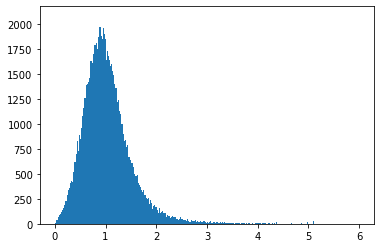

In [22]:
import matplotlib.pyplot as plt
# df.hist(column='lifetime_kd')
plt.hist(df['lifetime_kd'], range = (0,6), bins = 1000)

C:\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='lifetime_kd', ylabel='Density'>

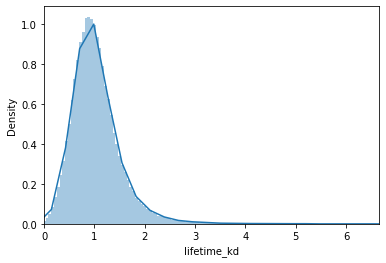

In [31]:
import seaborn as sb 
plt = sb.distplot(a = df['lifetime_kd'], bins = 1000, hist = True)
plt.set_xlim(0, 6.65)
plt